In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
#from keras.layers import Input, Conv2D, MaxPooling2D, PReLU, Flatten, Dense
from keras.layers import  Dense
global image_h
global image_w
global num_landmarks

In [48]:
# create folder to save the files we want
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
# X is the input image and Y is the landmarks

def load_dataset(path):
  print('hi2')
  # we are going  to the train folder and images and extraxt the images for x
  train_x = sorted(glob(os.path.join(path, "train2", "images", "*.png")))
  train_y = sorted(glob(os.path.join(path, "train2", "landmarks", "*.txt")))

  valid_x = sorted(glob(os.path.join(path, "valid2", "images", "*.png")))
  valid_y = sorted(glob(os.path.join(path, "valid2", "landmarks", "*.txt")))

  test_x = sorted(glob(os.path.join(path, "test", "images", "*.png")))
  test_y = sorted(glob(os.path.join(path, "test", "landmarks", "*.txt")))

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [4]:
# we read the image and resize it to out desired height and width then normalize it
def read_image_lankmarks(image_path, landmark_path):
    """ Image """
    #print('reading', image_path)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR) # this reads the image and returns a numpy arra
    try:
        h, w, _ = image.shape
    except ValueError:
            print('ERRR', image_path)

    image = cv2.resize(image, (image_w, image_h))
    image = image/255.0
    image = image.astype(np.float32) # image will be a numpy array (image_h, image_w, 3)

    """ Lankmarks """
    data = open(landmark_path, "r").read()
    lankmarks = []
    line_count = 0

    #print('path', landmark_path)
    # the first line of the file is number of the landmarks and we don't want it
    for line in data.strip().split("\n"):
        # x, y = line.split(" ")
        # # we normalize the landmarks and because maximum number of the landmarks are its width or height we divide them
        # # output values will be between 0 and 1
        # x = float(x)/w
        # y = float(y)/h
        try:
            x, y = line.split(" ")
            x = float(x) / w
            y = float(y) / h
        except ValueError:
            # Handle the case where the split operation fails
            print('error', landmark_path)
        lankmarks.append(x)
        lankmarks.append(y)

        #THIS IS A TEST
        # line_count += 1
        # # Break out of the loop after reading the first 4 lines
        # if line_count >= 5:
        #     break
    # landmarks will be an array of 106*2 we have 106 dots, and two values of the x and y position
    lankmarks = np.array(lankmarks, dtype=np.float32)

    return image, lankmarks

In [5]:
# x is the image path and y is landmark path
def preprocess(x, y):
    # we need to decode the file paths so we are able to put them in read_image_landmarks() function
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image, landmarks = read_image_lankmarks(x, y)
        return image, landmarks

    image, landmarks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([image_h, image_w, 3])
    landmarks.set_shape([num_landmarks * 2])

    return image, landmarks
# we go through the files in our folders
def tf_dataset(x, y, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(buffer_size=5000).map(preprocess)
    ds = ds.batch(batch).prefetch(2)
    return ds


In [46]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.layers import SeparableConv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout



from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.initializers import he_normal

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam




from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



def build_model(input_shape=(60, 80, 3), num_landmarks=10):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))
    
    # Adjust the last convolutional layer
    model.add(Conv2D(256, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(1024, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same'))
    model.add(MaxPooling2D((2, 2)))  
    # model.add(Conv2D(512, (5, 5), activation='relu', padding='same'))
    # model.add(MaxPooling2D((2, 2)))    
    # model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2))
    # Flatten the output and add fully connected layers
    model.add(Flatten())
    #model.add(GlobalAveragePooling2D())

    model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))

    model.add(Dense(2048, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))


    # model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
    # model.add(Dropout(0.2))

  
    model.add(Dense(num_landmarks * 2, activation='linear'))  # Assuming each landmark has x and y coordinates

    return model







In [49]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    image_h = 60 # height of the image ( we can decrease this)
    image_w = 80
    num_landmarks = 14 # number of landmarks( this should be the number of landmarks in txt file so don't just change it)
    input_shape = (image_h, image_w, 3)
    batch_size = 64
    lr = 1e-3
    num_epochs = 20

    """ Paths """

    dataset_path = "C:/Users/sabaa/My Jupyter/Facial Recognition/SabaDataset2"
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")
    

    """ Dataset Pipeline """
    train_ds = tf_dataset(train_x, train_y, batch=batch_size)
    valid_ds = tf_dataset(valid_x, valid_y, batch=batch_size)    
    # train_ds = tf_dataset(valid_x[:1200], valid_y[:1200], batch=batch_size)
    # valid_ds = tf_dataset(valid_x[1201:], valid_y[1201:], batch=batch_size)
    # train_ds = tf_dataset(train_x[:2000], train_y[:2000], batch=batch_size)
    # valid_ds = tf_dataset(train_x[2001:2401], train_y[2001:2401], batch=batch_size)
    # train_ds = tf_dataset(train_x[401:], train_y[401:], batch=batch_size)
    # valid_ds = tf_dataset(train_x[:400], train_y[:400], batch=batch_size)    
    """ Model """
    model = build_model(input_shape, num_landmarks)
    #model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(lr))
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mean_squared_error', metrics=['mae'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mae', metrics=['mse'])    
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=['mean_squared_error', 'mean_squared_error'], metrics=['mae'])

    #model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr))
    """ Training """
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]

    model.fit(train_ds,
        validation_data=valid_ds,
        epochs=num_epochs,
        callbacks=callbacks
              
    )



hi2
Train: 1720/1720 - Valid: 303/303 - Test: 7/7

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.2523 - mse: 0.2431
Epoch 1: val_loss improved from inf to 0.09206, saving model to files\model.h5
27/27 [==============================] - 154s 6s/step - loss: 0.2523 - mse: 0.2431 - val_loss: 0.0921 - val_mse: 0.0137 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.1007 - mse: 0.0167
Epoch 2: val_loss improved from 0.09206 to 0.06307, saving model to files\model.h5
27/27 [==============================] - 101s 4s/step - loss: 0.1007 - mse: 0.0167 - val_loss: 0.0631 - val_mse: 0.0069 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.0715 - mse: 0.0086
Epoch 3: val_loss did not improve from 0.06307
27/27 [==============================] - 100s 4s/step - loss: 0.0715 - mse: 0.0086 - val_loss: 0.0645 - val_mse: 0.0065 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 0.0583

In [50]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

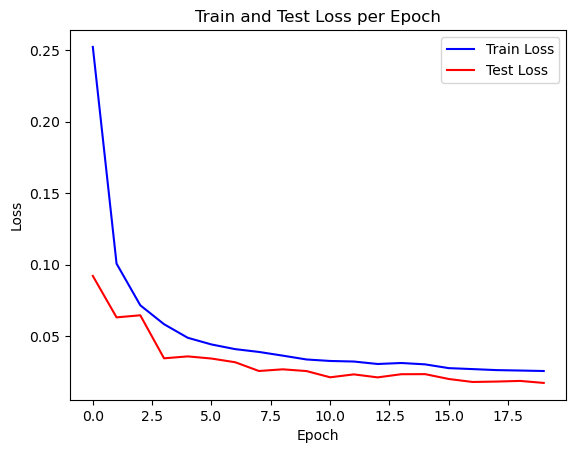

In [51]:

# Set the path to your CSV file
csv_path = os.path.join("files", "data.csv")

# Load data from CSV
df = pd.read_csv(csv_path)

# Example: Assuming your CSV file has columns 'epoch', 'train_loss', and 'test_loss'
# Replace these column names with your actual column names
epoch = df['epoch']
train_loss = df['loss']
test_loss = df['val_loss']

# Plotting the train loss
plt.plot(epoch, train_loss, label='Train Loss', color='blue')

# Plotting the test loss
plt.plot(epoch, test_loss, label='Test Loss', color='red')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')

# Adding legend
plt.legend()

# Display the plot
plt.show()


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

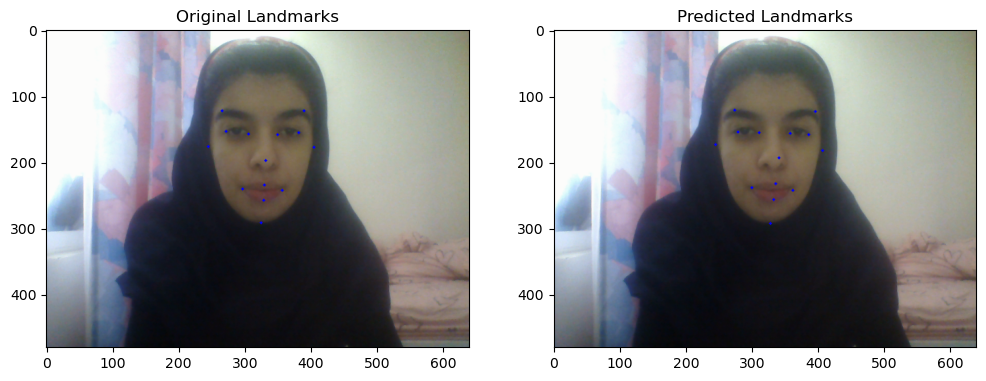

 14%|████████████                                                                        | 1/7 [00:02<00:13,  2.24s/it]

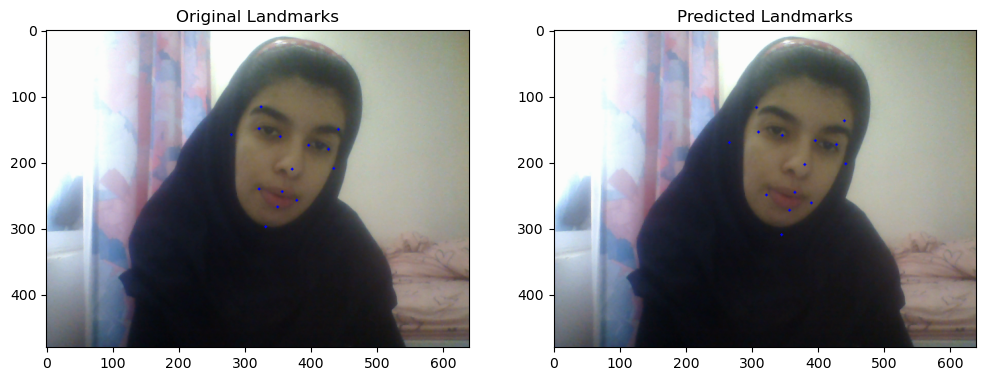

 29%|████████████████████████                                                            | 2/7 [00:04<00:10,  2.05s/it]

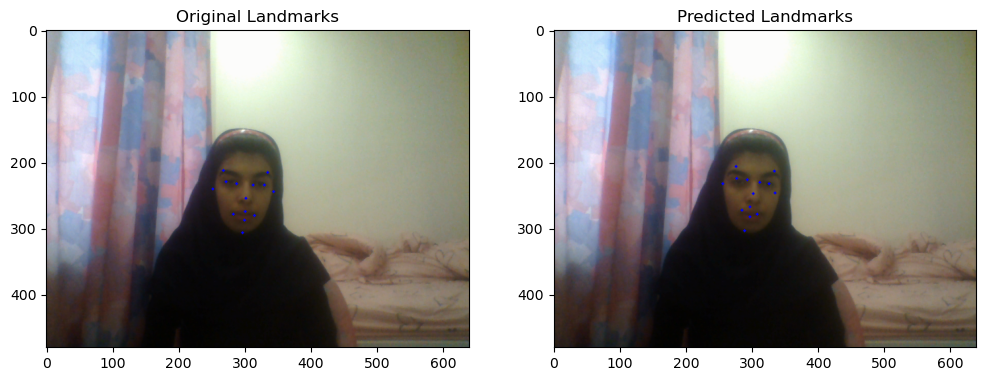

 43%|████████████████████████████████████                                                | 3/7 [00:05<00:07,  1.89s/it]

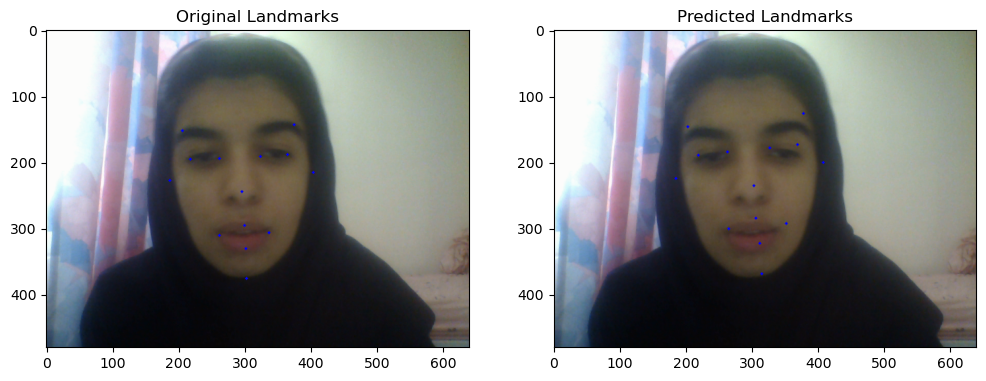

 57%|████████████████████████████████████████████████                                    | 4/7 [00:08<00:06,  2.18s/it]

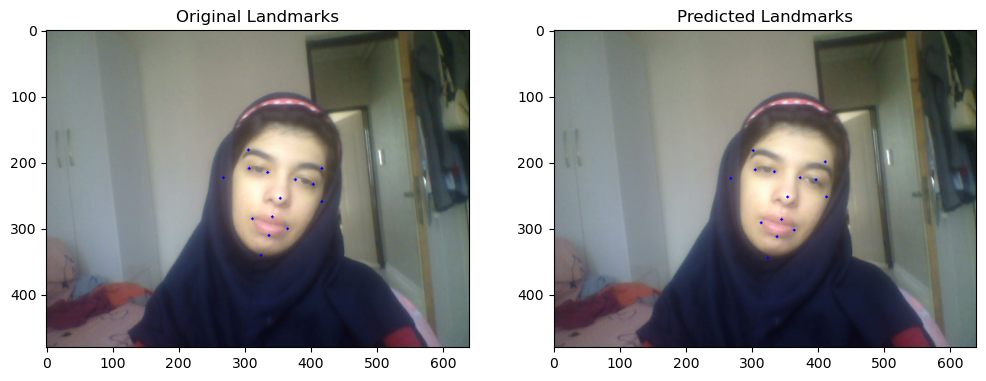

 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:10<00:04,  2.00s/it]

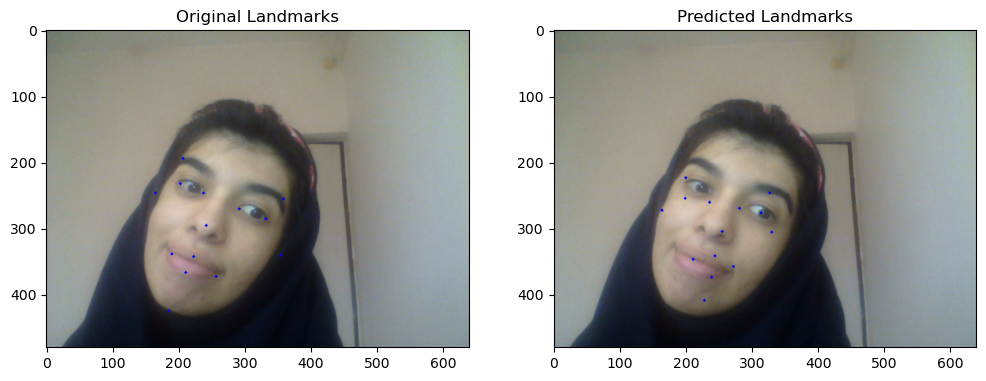

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:12<00:01,  1.97s/it]

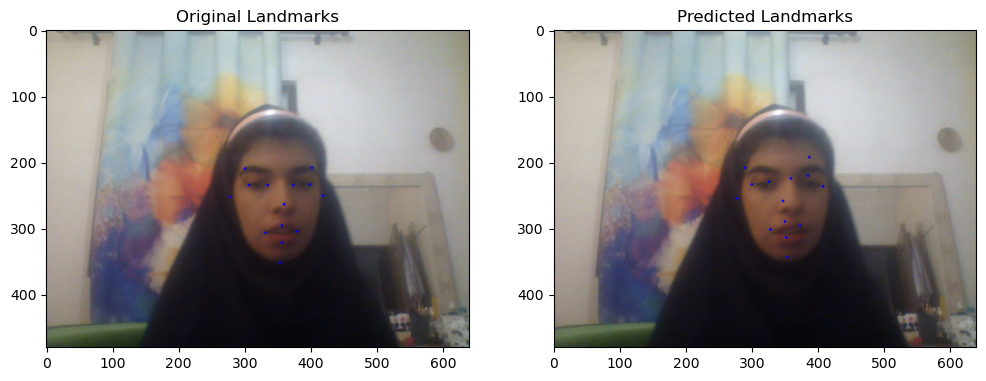

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.99s/it]


In [52]:
# this function get the image and landmarks and returns the image with landmarks on it
def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    radius = int(h * 0.005) # this is the thickness of the dots in the picture

    # We go through the pictures and put the dots in the positions in that picture
    for i in range(0, len(landmarks), 2):
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image
""" Prediction """
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extract the name """
    name = x.split("/")[-1].split(".")[0]

    """ Reading the image """
    image_x = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image_x, (image_w, image_h))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)

    """ Landmarks """
    data = open(y, "r").read()
    landmarks = []
    line_count = 0
    for line in data.strip().split("\n"):
        x, y = map(float, line.split(" "))
        x = x / image_x.shape[1]
        y = y / image_x.shape[0]
        landmarks.extend([x, y])
                    # THIS IS A TEST
        # line_count += 1

        # # Break out of the loop after reading the first 4 lines
        # if line_count >= 5:
        #     break

    landmarks = np.array(landmarks, dtype=np.float32)

    """ Prediction """
    pred = model.predict(image, verbose=0)[0]
    pred = pred.astype(np.float32)

    """ Visualizing the results """
    gt_landmarks = plot_lankmarks(image_x.copy(), landmarks)
    pred_landmarks = plot_lankmarks(image_x.copy(), pred)

    # Display the images with landmarks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(gt_landmarks[...,::-1])  # Convert BGR to RGB
    plt.title("Original Landmarks")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_landmarks[...,::-1])  # Convert BGR to RGB
    plt.title("Predicted Landmarks")

    plt.show()

In [14]:
# this function get the image and landmarks and returns the image with landmarks on it
def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    radius = int(h * 0.005) # this is the thickness of the dots in the picture

    # We go through the pictures and put the dots in the positions in that picture
    for i in range(0, len(landmarks), 2):
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Hyperparameters """
    # image_h = 512
    # image_w = 512
    # num_landmarks = 106

    """ Paths """
    # dataset_path = "/media/nikhil/Seagate Backup Plus Drive/ML_DATASET/LaPa"
    # model_path = os.path.join("files", "model.h5")

    """ Loading the dataset """
    # (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    # print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    # print("")

    """ Load the model """
    model = tf.keras.models.load_model(model_path)
    #model.summary()

    """ Prediction """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image_x = image
        image = cv2.resize(image, (image_w, image_h))
        image = image/255.0 ## (512, 512, 3)
        image = np.expand_dims(image, axis=0) ## (1, 512, 512, 3)
        image = image.astype(np.float32)

        """ Landmarks """
        data = open(y, "r").read()
        landmarks = []
        line_count = 0
        for line in data.strip().split("\n"):
            x, y = line.split(" ")
            x = float(x)/image_x.shape[1]
            y = float(y)/image_x.shape[0]

            landmarks.append(x)
            landmarks.append(y)

            # THIS IS A TEST
            line_count += 1

            # Break out of the loop after reading the first 4 lines
            if line_count >= 5:
                break
        landmarks = np.array(landmarks, dtype=np.float32)

        """ Prediction """
        pred = model.predict(image, verbose=0)[0]
        pred = pred.astype(np.float32)
        # print('pred', pred)
        """ Saving the results """
        gt_landmarks = plot_lankmarks(image_x.copy(), landmarks)
        pred_landmarks = plot_lankmarks(image_x.copy(), pred)
        line = np.ones((image_x.shape[0], 10, 3)) * 255

        cat_images = np.concatenate([gt_landmarks, line, pred_landmarks], axis=1)
        cv2.imwrite(f"results/{name}.png", cat_images)






    ## ...

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]
